# **10. Image Segmentation**

In [7]:
from configs.config import DATA_PATH
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

path = os.path.join(DATA_PATH, 'image', 'opencv_image7.jpg')
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img_ycrcb = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)

* Thresholding을 이용한 segmentation은 [이전 포스팅][https://xkdls19.tistory.com/13]에서 했으니까 넘어간다.

## **1. K-means Clustering**

* 이미지의 경우, edge를 제외하면 인접한 위치에 있는 픽셀들은 비슷한 밝기를 가지고 있다.

* 이를 이용해서 Clusting을 해주고, 밝기 레벨을 매핑해주어 클러스터링을 한다.

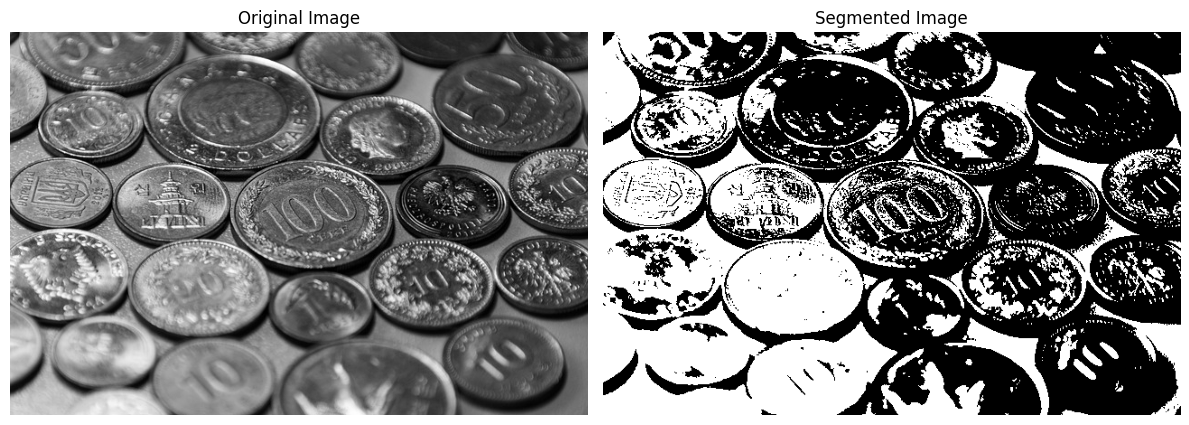

In [20]:
Y_channel = img_ycrcb[:,:,0]

Z = Y_channel.reshape((-1,1))
K = 2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, # 두 조건 하나라도 만족하면 종료
            100, # 반복 횟수
            0.2) # 임계치
_, labels, centers = cv2.kmeans(Z.astype(np.float32),
                                K, # 밝기 레벨 2개로
                                None,
                                criteria,
                                10, # K means 반복 횟수
                                cv2.KMEANS_RANDOM_CENTERS) # 클러스터 중심 랜덤하게

img_segmented = centers[labels.flatten()].reshape(Y_channel.shape).astype(np.uint8)

images = [img_gray, img_segmented]
titles = ['Original Image', 'Segmented Image']

plt.figure(figsize=(12,6))

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## **2. Watershed 알고리즘**

* 전경과 배경을 분리하는 고전적인 알고리즘 중 하나.

* 알고리즘이 더 잘 동작할 수 있게, 테두리를 명확하게 해주는 작업을 해준 후 실행한다..

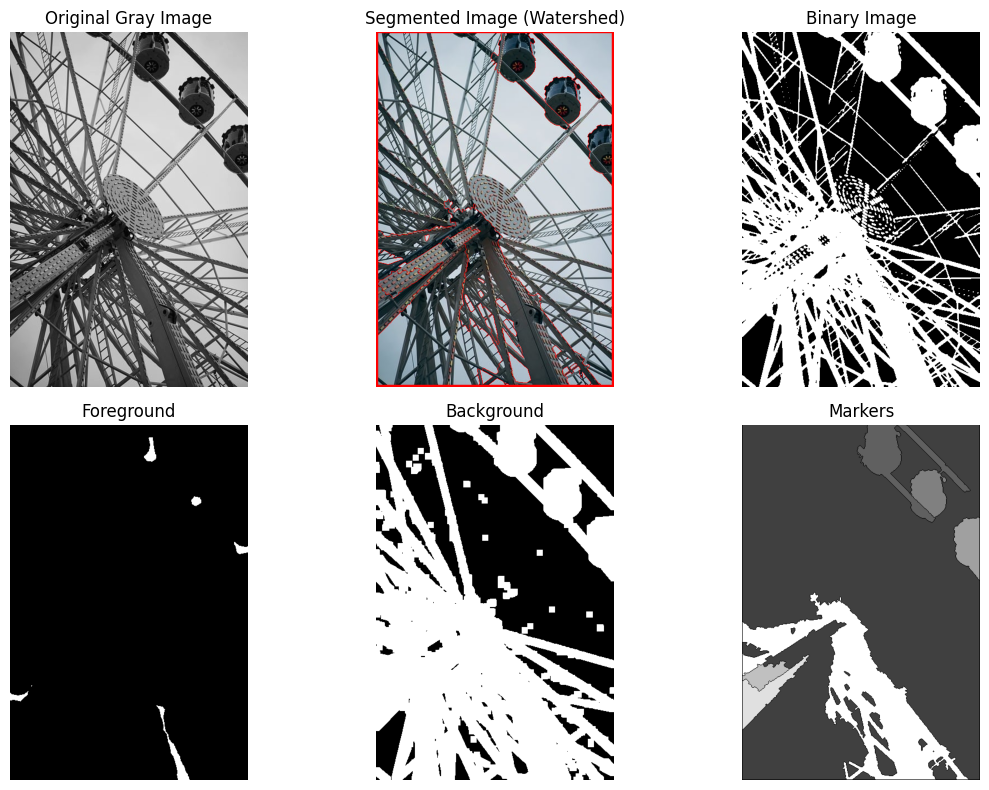

In [36]:
path = os.path.join(DATA_PATH, 'image', 'opencv_image1.jpg')
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img_ycrcb = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)


# step 1: 확실한 배경 찾기 (gaussian + otsu -> opening)
blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
_, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

# step 2: 확실한 전경 영역 찾기 (Distance Transform)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# step 3: 불확실한 영역 찾기 (확실한 영역 빼서 불확실한 부분 찾기)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# step 4: 마커 라벨링 : 연결된 구성요소에 labeling -> 확실한 배경을 1로 설정 / 불확실 0
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0] # watershed가 찾은거는 -1

contours, _ = cv2.findContours(markers.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    cv2.drawContours(img, [contour], -1, (255, 0, 0), thickness=5)

images = [img_gray, img, binary, sure_fg, sure_bg, markers]
titles = ['Original Gray Image', 'Segmented Image (Watershed)', 'Binary Image',
          'Foreground', 'Background', 'Markers']

plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()